In [500]:
import numpy as np
import cv2
from matplotlib import pyplot as plt 

In [501]:
def define_roi(img, max_display_size=800, window_name="Select ROI"):
    """
    Displays a resizable window for ROI selection, then returns the cropped ROI from the original image.

    Parameters:
    - img: np.ndarray, the original image
    - max_display_size: int, maximum width or height to resize image for display (default: 800)
    - window_name: str, name of the selection window

    Returns:
    - cropped_img: np.ndarray, the cropped region of interest from the original image
    - (x, y, w, h): tuple of ROI coordinates in the original image
    """
    orig_h, orig_w = img.shape[:2]
    scale = min(max_display_size / orig_w, max_display_size / orig_h, 1.0)

    # Resize image for easier selection
    resized_w, resized_h = int(orig_w * scale), int(orig_h * scale)
    resized_image = cv2.resize(img, (resized_w, resized_h))

    # Let user select ROI
    roi = cv2.selectROI(window_name, resized_image, showCrosshair=True, fromCenter=False)
    cv2.destroyAllWindows()

    # Convert ROI coordinates back to original scale
    x, y, w, h = roi
    x = int(x / scale)
    y = int(y / scale)
    w = int(w / scale)
    h = int(h / scale)

    cropped_img = img[y:y+h, x:x+w]
    return cropped_img, (x, y, w, h)

def hist_equalize(img):
    '''
    Histogram equalization for grayscale or color images.
    '''
    if len(img.shape) == 2:
        equalized_img = cv2.equalizeHist(img)
    else:
        channels = cv2.split(img)
        equalized_channels = [cv2.equalizeHist(ch) for ch in channels]
        equalized_img = cv2.merge(equalized_channels)

    return equalized_img

def preprocess_img(img, ksize=5, canny_low_thresh=30, canny_up_thresh=100):
    '''
    Convert to gray, equalize histogram, denoise using Gaussian, and detect edges
    before finding the outlines.
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = hist_equalize(gray)
    # blur = cv2.GaussianBlur(equalized, (ksize, ksize), 0)
    blur = cv2.bilateralFilter(equalized, d=5, sigmaColor=15, sigmaSpace=10) # avoids blurring the edges
    edges = cv2.Canny(blur, canny_low_thresh, canny_up_thresh)
    
    return edges

In [18]:
cv2.imwrite('test2.png', result)

True

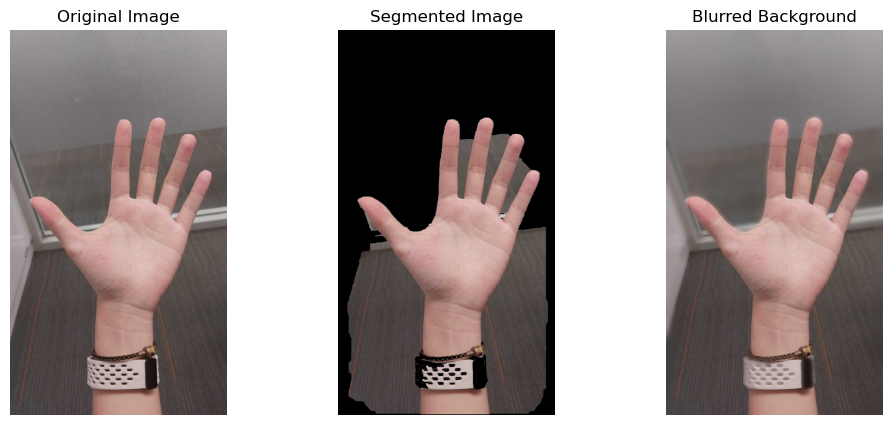

In [505]:
# image = cv2.imread('../images/clay.png')
image = cv2.imread('../images/hand.jpg')
# image = cv2.imread('harmo.png')
mask = np.zeros(image.shape[:2], np.uint8)

# specify the background and foreground model
# using numpy the array is constructed of 1 row
# and 65 columns, and all array elements are 0
# Data type for the array is np.float64 (default)
backgroundModel = np.zeros((1, 65), np.float64)
foregroundModel = np.zeros((1, 65), np.float64)
 
# define the Region of Interest (ROI)
# as the coordinates of the rectangle
# where the values are entered as
# (startingPoint_x, startingPoint_y, width, height)
# these coordinates are according to the input image
# it may vary for different images
cropped_img, rectangle = define_roi(image)
 
# apply the grabcut algorithm with appropriate
# values as parameters, number of iterations = 3 
# cv2.GC_INIT_WITH_RECT is used because
# of the rectangle mode is used 
cv2.grabCut(image, mask, rectangle,  
            backgroundModel, foregroundModel,
            3, cv2.GC_INIT_WITH_RECT)
 
# In the new mask image, pixels will 
# be marked with four flags 
# four flags denote the background / foreground 
# mask is changed, all the 0 and 2 pixels 
# are converted to the background
# mask is changed, all the 1 and 3 pixels
# are now the part of the foreground
# the return type is also mentioned,
# this gives us the final mask
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
 
# The final mask is multiplied with 
# the input image to give the segmented image.
image_segmented = image * mask2[:, :, np.newaxis]
image_blurred = cv2.GaussianBlur(image, (35,35), 0)

# Expand mask2 to 3 channels to match image shape
mask3 = mask2[:, :, np.newaxis]

# Composite: for foreground pixels use original, else blurred
result = image * mask3 + image_blurred * (1 - mask3)
result = result.astype(np.uint8)  # ensure uint8 for display

plt.figure(figsize=(12, 5))

# output segmented image with colorbar
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the segmented image
plt.subplot(132)
plt.title('Segmented Image')
plt.imshow(cv2.cvtColor(image_segmented, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the segmented image
plt.subplot(133)
plt.title('Blurred Background')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [23]:
cv2.imwrite('segmented_clay.png', image_segmented)

True

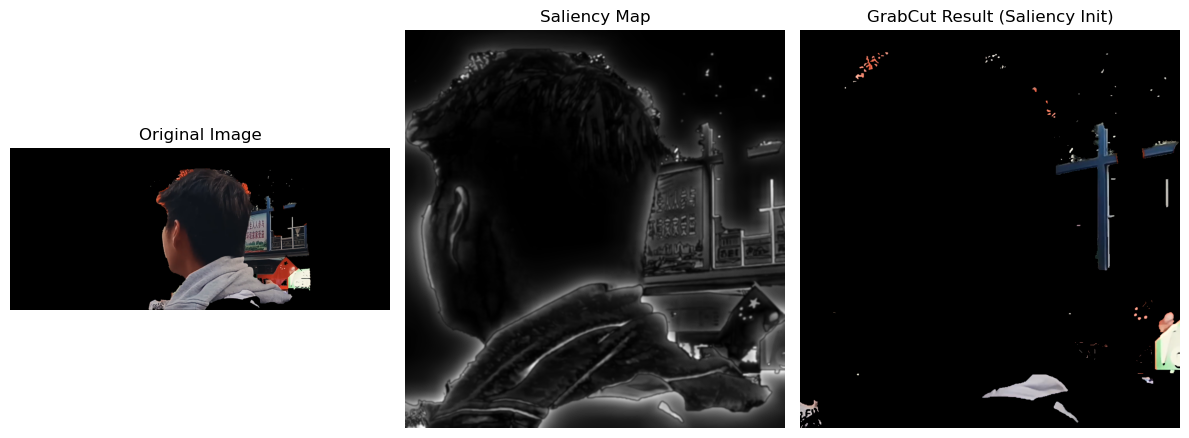

In [25]:
def get_saliency_mask(img, threshold=0.3):
    """
    Compute saliency map and threshold it to get binary mask.
    """
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    success, saliencyMap = saliency.computeSaliency(img)
    if not success:
        raise Exception("Saliency computation failed")

    saliencyMap = cv2.GaussianBlur(saliencyMap, (7, 7), 0)
    binary_mask = (saliencyMap > threshold).astype('uint8')
    return binary_mask, saliencyMap

# --- Load image ---
# img_path = "../images/harmo.jpg"  # Change this if needed
img_path = "segmented_clay.png"  # Change this if needed
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")

cropped_img, rectangle = define_roi(img)

# --- Get saliency map and mask ---
binary_mask, saliency_map = get_saliency_mask(cropped_img, threshold=0.3)

# --- Prepare GrabCut mask ---
grabcut_mask = np.where(binary_mask == 1, cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype('uint8')

# --- Allocate GrabCut models ---
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# --- Run GrabCut ---
cv2.grabCut(cropped_img, grabcut_mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

# --- Convert GrabCut result to binary mask ---
final_mask = np.where(
    (grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 1, 0
).astype('uint8')

# --- Apply mask to original image ---
segmented_img = cropped_img * final_mask[:, :, np.newaxis]

# --- Plot Results ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap="gray")
plt.title("Saliency Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title("GrabCut Result (Saliency Init)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
gray = cv2.cvtColor(saliency_map, cv2.COLOR_BGR2GRAY)  # if not already grayscale
gray = np.clip(gray, 0, 255).astype("uint8")    # ensure proper type
edges = cv2.Canny(gray, 50, 150)

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x6f7fe6c3::Set<1,-1,-1>,struct cv::impl::A0x6f7fe6c3::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [30]:
cv2.imwrite('segment.png', image_segmented)

True

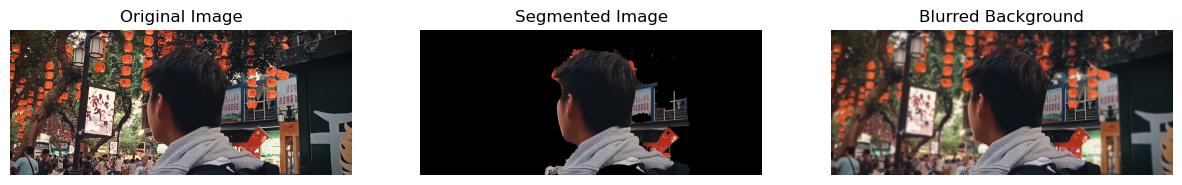

In [17]:
# output segmented image with colorbar
plt.figure(figsize=(15, 7))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the segmented image
plt.subplot(132)
plt.title('Segmented Image')
plt.imshow(cv2.cvtColor(image_segmented, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the segmented image
plt.subplot(133)
plt.title('Blurred Background')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [20]:
def addPadding(img:np.ndarray) -> np.ndarray:
    '''
    Pads the input image with zeros to double its dimensions.

    The new padded image will have dimensions P x Q where:
        P = 2 * M (rows)
        Q = 2 * N (columns)
    The original image is placed in the top-left corner of the new image.

    Args:
        img (np.ndarray): Input 2D image (grayscale) as a NumPy array.

    Returns:
        np.ndarray: Zero-padded image of size (2M, 2N).
    '''
    M, N = img.shape
    P, Q = 2 * M, 2 * N
    padded_img = np.zeros((P,Q)) 
    padded_img[:M, :N] = img[:M, :N] 
    return padded_img

def getFourierSpectrum(img:np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    '''
    Computes the log-magnitude Fourier spectrum of the input image.

    The image is first zero-padded to double its size (2M x 2N),
    then the 2D Fast Fourier Transform is applied. The spectrum
    is shifted to center the low frequencies and converted to
    log scale to enhance visibility.

    Args:
        img (np.ndarray): Input 2D image (grayscale).

    Returns:
        tuple:
            - padded_img (np.ndarray): The zero-padded input image.
            - log_spectrum (np.ndarray): The log-magnitude spectrum of the image.
    '''
    padded_img = addPadding(img)
    f = np.fft.fft2(padded_img)
    fshift = np.fft.fftshift(f)
    spectrum = np.abs(fshift)
    log_spectrum = np.log(spectrum + 1)  # +1 to avoid log(0)
    return padded_img, log_spectrum

def normalizeSpectrum(spectrum:np.ndarray) -> np.ndarray:
    '''
    Normalizes the Fourier spectrum to the range [0, 1].

    This is done by dividing each element by the maximum value
    in the spectrum.

    Args:
        spectrum (np.ndarray): Input spectrum to normalize.

    Returns:
        np.ndarray: Normalized spectrum with values between 0 and 1.
    '''
    return spectrum / spectrum.max()

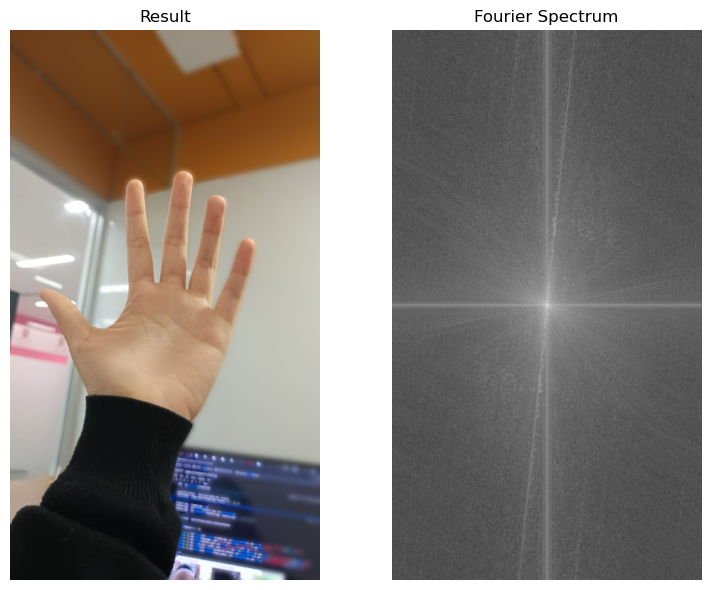

In [25]:
result_gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
padded_img, spectrum = getFourierSpectrum(result_gray)
normalized_spectrum = normalizeSpectrum(spectrum)

plt.figure(figsize=(8, 6))

plt.subplot(121); plt.title('Result'); plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(122); plt.title('Fourier Spectrum'); plt.imshow(normalized_spectrum, cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()